# Music & Mental Health Data Analysis: Sampling


## Description  
This notebook focuses on the exploration of imbalanced classes in the target variable, `improved`.

## Objectives  
- Load and review the dataset after feature engineering 
- Identify categorical features
- Explore various methods of balancing imbalanced data:
  - Oversampling with SMOTE-NC
  - Undersampling with Tomek Links
  - Hybrid: Undersampling then Oversampling with above techniques
- Ensure that the balancing techniques do not significantly alter the distributions of the independent variables
- Validate that the resulting dataset is ready for modeling

## Dataset Source  
- [Music & Mental Health Dataset on Kaggle](https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results)

## Notes  
- This notebook is part of a larger data science pipeline aimed at exploring the relationship between music preferences and mental health indicators  
- All preprocessing choices will be documented and justified in context

In [121]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Oversampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

# Statistics
from scipy import stats

from music_and_mental_health_survey_analysis.config import (
    PROCESSED_DATA_DIR, SAMPLING_EVALUATIONS_DIR, RAW_DATA_DIR, CONFIG_FILE, INTERIM_DATA_DIR
)
from music_and_mental_health_survey_analysis.config import (
    load_config_file
)

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
df = pd.read_csv(PROCESSED_DATA_DIR / 'features.csv')
df.head()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,improved,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Classical,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music
0,18.0,3.0,156.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0,3,0,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63.0,1.5,119.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,7,2,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,18.0,4.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0,7,7,10,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,61.0,2.5,84.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,9,7,3,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.0,4.0,107.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0,7,2,5,9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [124]:
raw_df = pd.read_csv(RAW_DATA_DIR / 'mxmh_survey_results.csv')
raw_df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,156.0,Rarely,Never,Rarely,Never,Never,Sometimes,Never,Very frequently,Very frequently,Rarely,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,119.0,Sometimes,Never,Never,Rarely,Sometimes,Rarely,Very frequently,Rarely,Sometimes,Rarely,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,132.0,Never,Never,Very frequently,Never,Never,Rarely,Rarely,Very frequently,Never,Sometimes,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,Never,Never,Rarely,Sometimes,Never,Very frequently,Sometimes,Very frequently,Sometimes,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,Never,Rarely,Never,Rarely,Very frequently,Never,Very frequently,Sometimes,Sometimes,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


# Oversampling

In [125]:
pd.get_dummies(raw_df['Primary streaming service'], dtype='category').dtypes

Apple Music                          category
I do not use a streaming service.    category
Other streaming service              category
Pandora                              category
Spotify                              category
YouTube Music                        category
dtype: object

In [126]:
# Split data into features and target

X = df.drop(labels=['improved'], axis=1)
y = df['improved'].astype(int)

In [127]:
dtype_dict = load_config_file(CONFIG_FILE)
numeric_cols = []
categorical_cols = []

# Iterate through df columns
for col in X.columns:
    # Get datatype information

    dtype = dtype_dict.get(col.split('_')[0])

    if dtype:
        if dtype.get('type') == 'numeric':
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    else:
        print(f"{col} skipped")

print(numeric_cols)
print(categorical_cols)

['Age', 'Hours per day', 'BPM']
['While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Primary streaming service_Apple Music', 'Primary streaming service_I do not use a streaming service.', 'Primary streaming service_Other streaming service', 'Primary streaming service_Pandora', 'Primary streaming service_Spotify', 'Primary streaming service_YouTube Music', 'Fav genre_Classical', 'Fav genre_Country', 'Fav genre_EDM', 'Fav genre_Folk', 'Fav genre_Gospel', 'Fav genre_Hip hop', 'Fav genre_Jazz', 'Fav genre_K pop', 'Fav genre_Latin', 'Fav genre_Lofi', 'Fav genre_Metal', 'Fav gen

In [128]:
# Get indeces of categorical features for SMOTE-NC
cat_cols_indeces = X.columns.get_indexer(categorical_cols).tolist()

In [129]:
# Initialize SMOTE-NC
smote_nc = SMOTENC(categorical_features=cat_cols_indeces)

# Apply to oversample
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [130]:
# Combine resampled data into dataframe

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df = pd.concat([resampled_df, pd.DataFrame(y_resampled, columns=['improved'])], axis=1)

In [131]:
resampled_df.head()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Classical,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music,improved
0,18.0,3.0,156.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0,3,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,63.0,1.5,119.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,7,2,2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,18.0,4.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0,7,7,10,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,61.0,2.5,84.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,9,7,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,18.0,4.0,107.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0,7,2,5,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [132]:
# Save data for later model evaluation

resampled_df.to_csv(INTERIM_DATA_DIR / 'oversampled.csv', index=False)

### Evaluate Oversampling

In [133]:
resampled_df['improved'].value_counts()

improved
1    539
0    539
Name: count, dtype: int64

#### Continuous Features

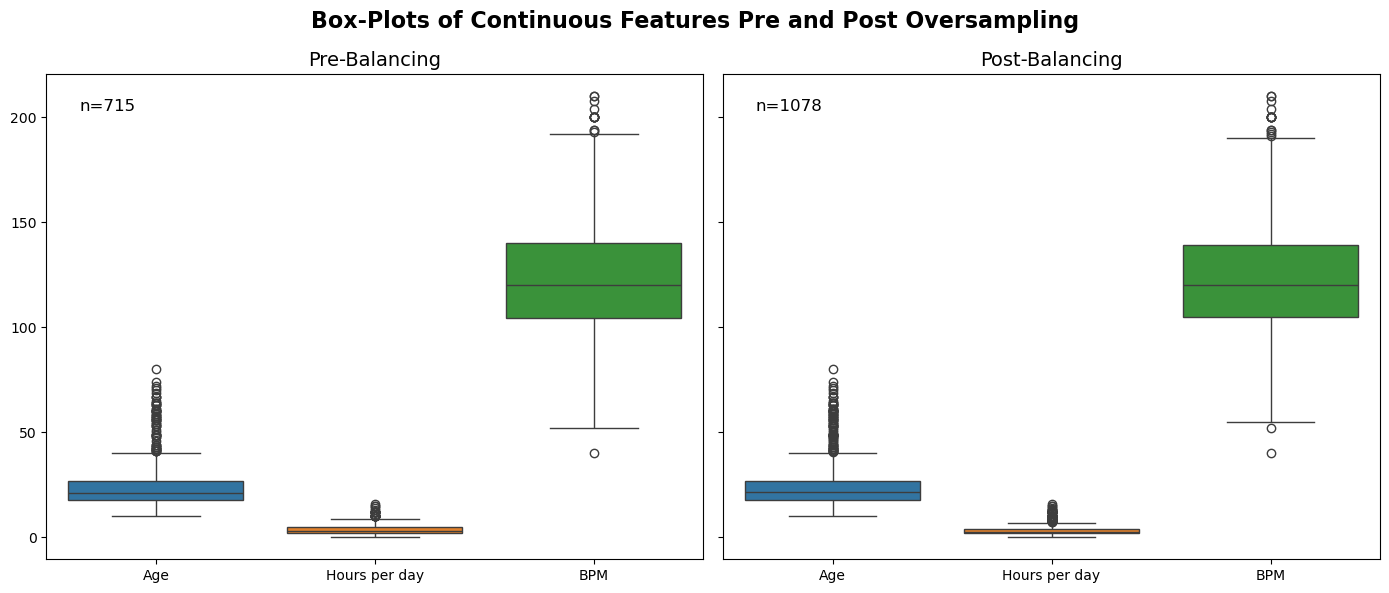

In [134]:
# Plot continuous feature boxplots pre and post imputation

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 6))

continuous_features = ['Age', 'Hours per day', 'BPM']

fig.suptitle('Box-Plots of Continuous Features Pre and Post Oversampling', fontsize=16, fontweight='bold')

sns.boxplot(df[continuous_features], ax=ax[0])
ax[0].set_title('Pre-Balancing', fontsize=14)
ax[0].text(0.05, 0.95, f"n={len(df)}", transform=ax[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

sns.boxplot(resampled_df[continuous_features], ax=ax[1])
ax[1].set_title('Post-Balancing', fontsize=14)
ax[1].text(0.05, 0.95, f"n={len(resampled_df)}", transform=ax[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_balancing_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

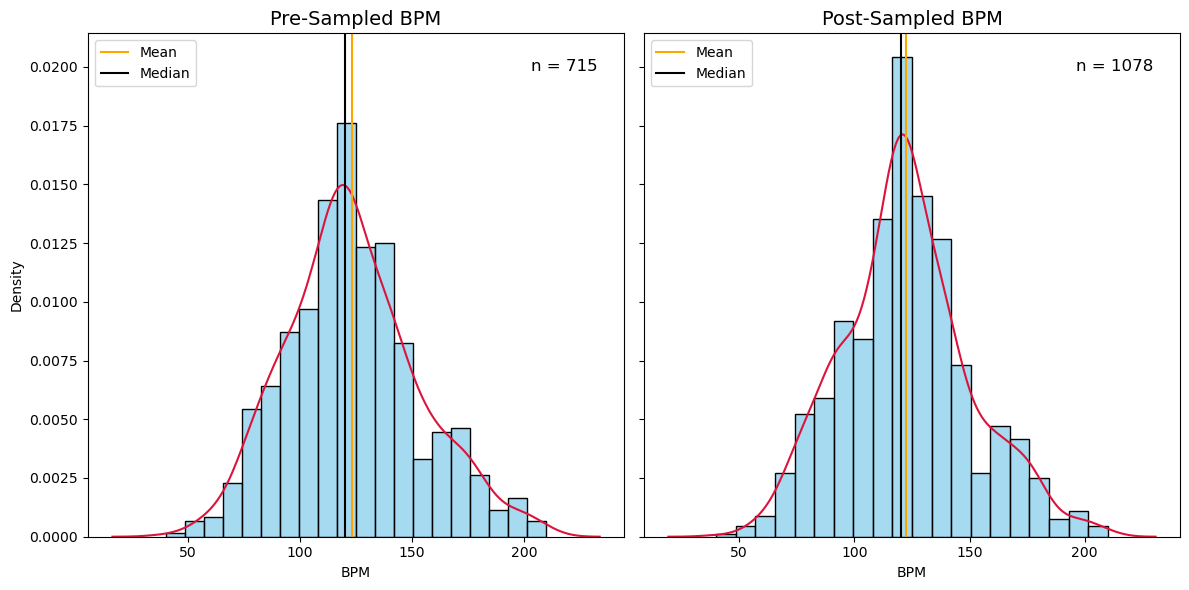

In [135]:
# Plot distributions of BPM pre and post imputation

pre_sampling_mean = np.mean(df['BPM'])
pre_sampling_median = np.median(df['BPM'])
post_sampling_mean = np.mean(resampled_df['BPM'])
post_sampling_median = np.median(resampled_df['BPM'])

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes = ax.flatten()

axes[0].set_title('Pre-Sampled BPM', fontsize=14)
sns.histplot(df['BPM'], stat='density', ax=axes[0], color='skyblue', bins=20)
sns.kdeplot(df['BPM'], ax=axes[0], color='crimson')
axes[0].axvline(pre_sampling_mean, color='orange', label='Mean')
axes[0].axvline(pre_sampling_median, color='black', label='Median')
axes[0].legend()
axes[0].text(0.95, 0.95, f'n = {len(df)}', transform=axes[0].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

axes[1].set_title('Post-Sampled BPM', fontsize=14)
sns.histplot(resampled_df['BPM'], stat='density', color='skyblue', bins=20, ax=axes[1])
sns.kdeplot(resampled_df['BPM'], color='crimson', ax=axes[1])
axes[1].axvline(post_sampling_mean, color='orange', label='Mean')
axes[1].axvline(post_sampling_median, color='black', label='Median')
axes[1].legend()
axes[1].text(0.95, 0.95, f'n = {len(resampled_df)}', transform=axes[1].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_oversample_bpm.png', dpi=300, bbox_inches='tight')
plt.show()

It appears like the normal curve post-oversampling is **slightly altered**. Normality will be verified using **Q-Q plots** of both datasets.

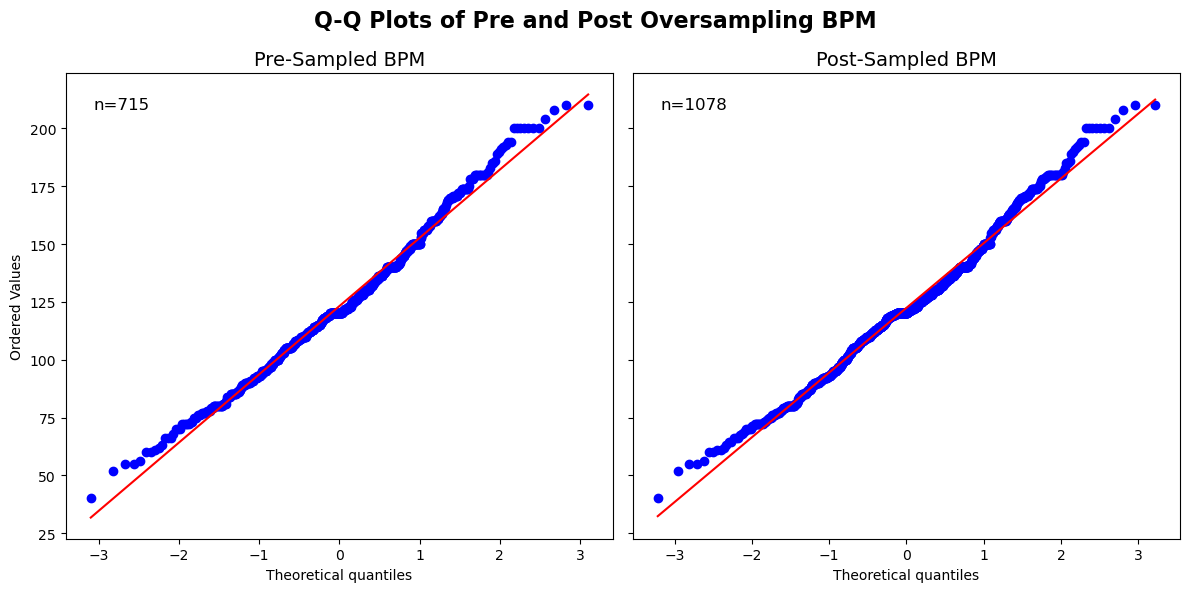

In [136]:
# Plot qq plots to verify normality

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

axes = ax.flatten()

fig.suptitle('Q-Q Plots of Pre and Post Oversampling BPM', fontsize=16, fontweight='bold')

plt.sca(axes[0])
stats.probplot(df['BPM'], dist='norm', plot=plt)
axes[0].set_title('Pre-Sampled BPM', fontsize=14)
axes[0].text(0.05, 0.95, s=f"n={len(df)}", transform=axes[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.sca(axes[1])
stats.probplot(resampled_df['BPM'], dist='norm', plot=plt)
axes[1].set_title('Post-Sampled BPM', fontsize=14)
axes[1].set_ylabel('')
axes[1].text(0.05, 0.95, s=f"n={len(resampled_df)}", transform=axes[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'qq_pre_post_oversampling_bpm.png', dpi=300, bbox_inches='tight')
plt.show()

##### Summary
- The distribution of `BPM` pre and post oversampling remains identical aside for a **higher central tendency**.
- `BPM` remains **normally distributed** post oversampling.

#### Categorical Features

##### Frequency

In [137]:
freq_cols = [col for col in df.columns if col.startswith('Frequency ')]

df[freq_cols]

,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music]
0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0
1,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0
2,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0
3,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,3.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,3.0,0.0
711,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0
712,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0
713,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [138]:
# Unpivot data for plotting

melted_df = df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_resampled_df = resampled_df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_df['Genre'] = melted_df['Genre'].str.strip('Frequency ').str.slice(1, -1)
melted_resampled_df['Genre'] = melted_resampled_df['Genre'].str.strip('Frequency ').str.slice(1, -1)

In [139]:
# Combine into one df

melted_df['Source'] = 'Pre-Sampling'
melted_resampled_df['Source'] = 'Post-Sampling'

combined_df = pd.concat([melted_df, melted_resampled_df])

<Figure size 1200x600 with 0 Axes>

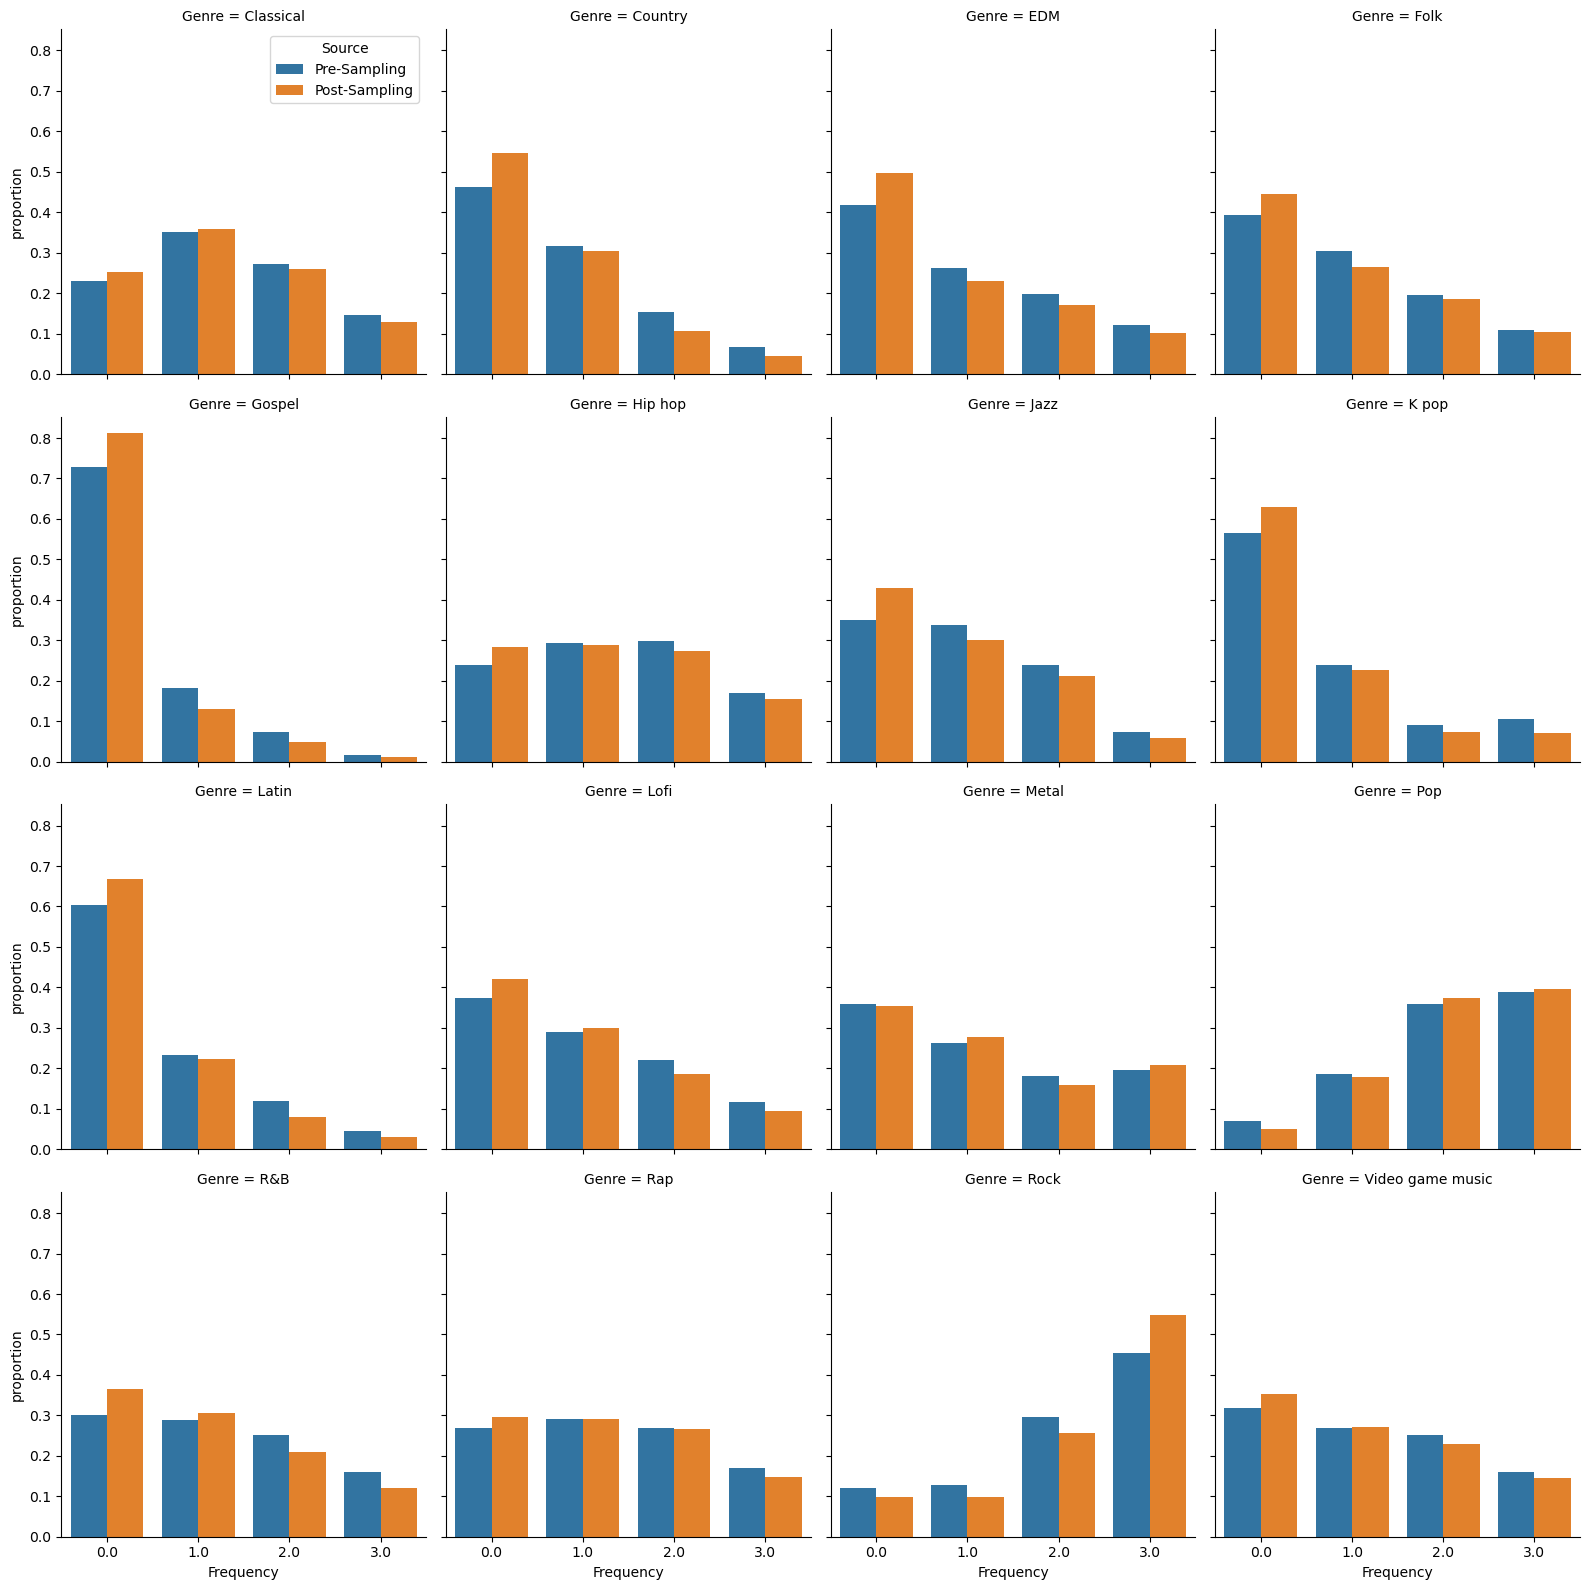

In [140]:
# Plot proportions from both datasets for comparison
grouped_combined = combined_df.groupby(by=['Source', 'Genre']).value_counts(normalize=True).reset_index()

plt.figure(figsize=(12, 6))

sns.catplot(
    data=grouped_combined,
    x='Frequency',
    y='proportion',
    kind='bar',
    col='Genre',
    col_wrap=4,
    hue='Source',
    hue_order=['Pre-Sampling', 'Post-Sampling'],
    height=4,
    dodge=True,
    legend_out=False
)

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'bar_pre_post_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

##### Illness

In [141]:
# Prepare data for plotting in long form

illness_cols = ['Anxiety', 'OCD', 'Depression', 'Insomnia']

melted_df = df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_resampled_df = resampled_df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_df['Source'] = 'Pre-Sampling'
melted_resampled_df['Source'] = 'Post-Sampling'

# Combine into one dataframe
combined_df = pd.concat([melted_df, melted_resampled_df])

# Convert rank to string since ordinal not continuous
combined_df['Rank'] = combined_df['Rank'].astype(int).astype(str)

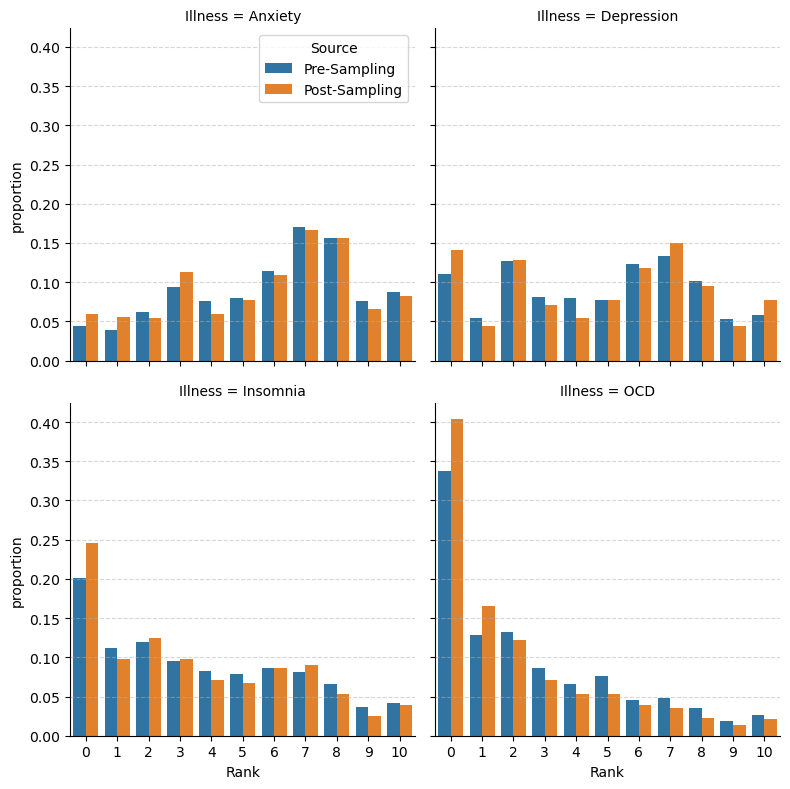

In [142]:
# Plot illness data pre and post imputation for comparison
grouped_combined = combined_df.groupby(by=['Illness', 'Source']).value_counts(normalize=True).reset_index()

plot = sns.catplot(
    data=grouped_combined,
    x='Rank',
    y='proportion',
    col='Illness',
    col_wrap=2,
    kind='bar',
    hue='Source',
    hue_order=['Pre-Sampling', 'Post-Sampling'],
    order=list(range(11)),
    height=4,
    legend_out=False,
)

for ax in plot.axes:
    ax.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'illness_pre_post_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

##### Summary
- Genre frequency distributions were **notably altered** after SMOTE-NC oversampling.
  - For example, the proportion of respondents who never listened to EDM **increased** from approximately 40% to over 60%, while the proportions of other frequency categories declined.
- In the majority of categorical features, SMOTE-NC smoothed the distribution, reducing the presence of extreme or sparse categories.
- Certain categorical values experienced disproportionate increases, which may introduce bias or affect model interpretability:
- The proportion of participants with a `Depression` score of 10 **increased** from 5% to 25%.
- The proportion with an `Anxiety` score of 7 **increased** from ~17% to ~27%.

## Undersampling

### Tomek Links

In order to apply **Tomek Links** to *undersample* the majority class (`Improve`), we'll create a binary column for whether or not an individual improved following therapy.

In [143]:
# Apply Tomek Links for undersampling

X = df.drop(labels=['improved'], axis=1)
y = df['improved']

# Apply undersampling
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X, y)

# Recombine into dataframe
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df = pd.concat([resampled_df, pd.DataFrame(y_resampled, columns=['improved'])], axis=1)

In [144]:
len(df[df['improved'] == 1]) / len(df) * 100

75.38461538461539

In [145]:
len(resampled_df[resampled_df['improved'] == 1]) / len(resampled_df) * 100

73.2928679817906

In [146]:
resampled_df.to_csv(INTERIM_DATA_DIR / 'undersampled.csv', index=False)

#### Evaluate Continuous

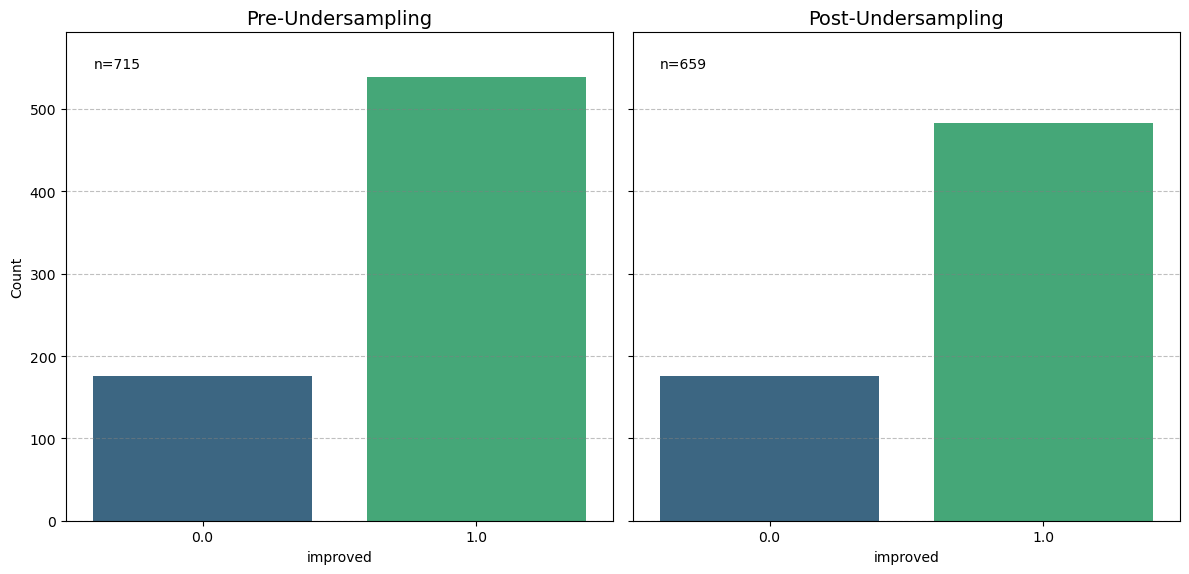

In [147]:
# Plot Improved to see balancing distribution

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharey=True)

fig.suptitle('')

sns.countplot(
    data=df,
    x='improved',
    ax=ax[0],
    palette='viridis',
    hue='improved',
    legend=False
)
ax[0].set_title('Pre-Undersampling', fontsize=14)
ax[0].text(0.05, 0.95, transform=ax[0].transAxes, s=f"n={len(df)}", va='top', ha='left')
ax[0].set_ylabel('Count')
ax[0].grid(axis='y', color='gray', linestyle='--', alpha=0.5)

sns.countplot(
    data=resampled_df,
    x='improved',
    ax=ax[1],
    hue='improved',
    legend=False,
    palette='viridis'
)
ax[1].set_title('Post-Undersampling', fontsize=14)
ax[1].text(0.05, 0.95, transform=ax[1].transAxes, s=f"n={len(resampled_df)}", va='top', ha='left')
ax[1].set_ylim(0, len(resampled_df) * 0.9)
ax[1].grid(axis='y', color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'bar_pre_post_tomek.png', dpi=300, bbox_inches='tight')
plt.show()

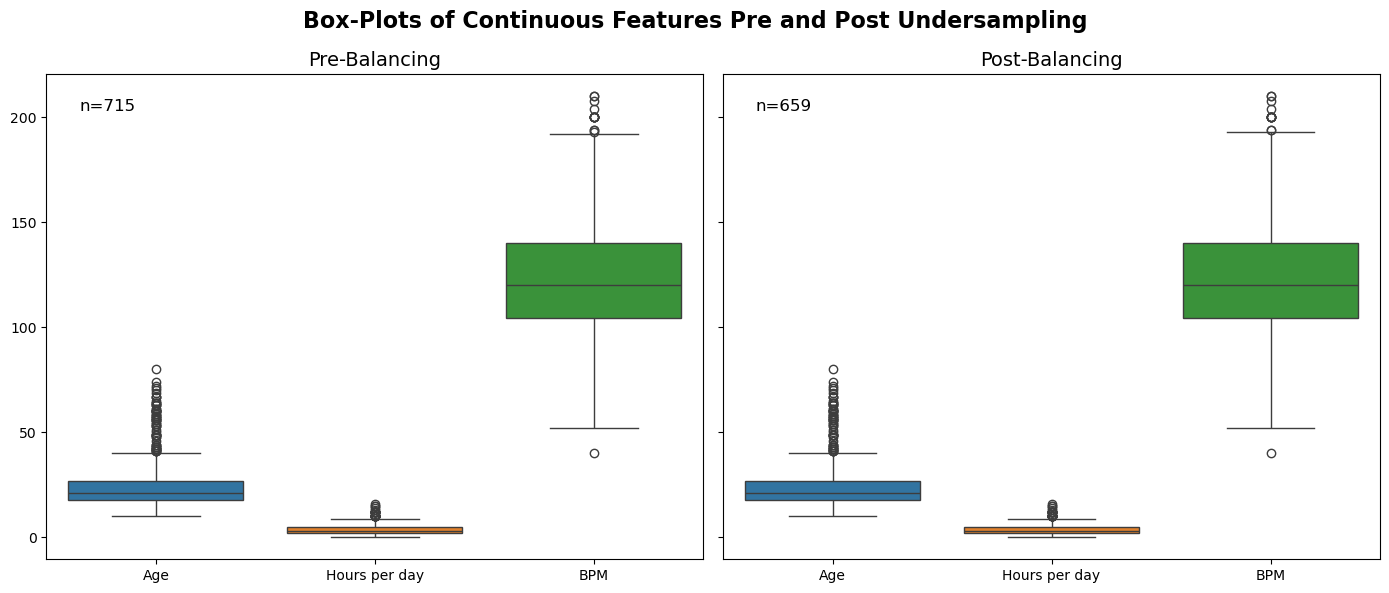

In [148]:
# Plot continuous feature boxplots pre and post imputation

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 6))

fig.suptitle('Box-Plots of Continuous Features Pre and Post Undersampling', fontsize=16, fontweight='bold')

sns.boxplot(df[continuous_features], ax=ax[0])
ax[0].set_title('Pre-Balancing', fontsize=14)
ax[0].text(0.05, 0.95, f"n={len(df)}", transform=ax[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

sns.boxplot(resampled_df[continuous_features], ax=ax[1])
ax[1].set_title('Post-Balancing', fontsize=14)
ax[1].text(0.05, 0.95, f"n={len(resampled_df)}", transform=ax[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_tomek_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

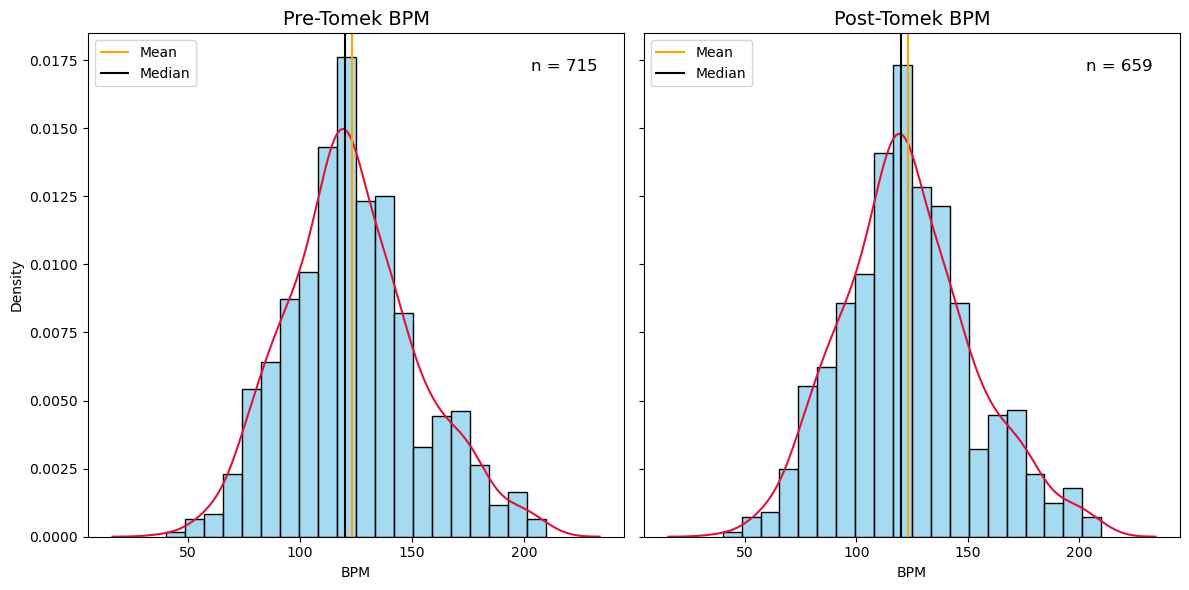

In [149]:
# Plot distributions of BPM pre and post imputation

pre_sampling_mean = np.mean(df['BPM'])
pre_sampling_median = np.median(df['BPM'])
post_sampling_mean = np.mean(resampled_df['BPM'])
post_sampling_median = np.median(resampled_df['BPM'])

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes = ax.flatten()

axes[0].set_title('Pre-Tomek BPM', fontsize=14)
sns.histplot(df['BPM'], stat='density', ax=axes[0], color='skyblue', bins=20)
sns.kdeplot(df['BPM'], ax=axes[0], color='crimson')
axes[0].axvline(pre_sampling_mean, color='orange', label='Mean')
axes[0].axvline(pre_sampling_median, color='black', label='Median')
axes[0].legend()
axes[0].text(0.95, 0.95, f'n = {len(df)}', transform=axes[0].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

axes[1].set_title('Post-Tomek BPM', fontsize=14)
sns.histplot(resampled_df['BPM'], stat='density', color='skyblue', bins=20, ax=axes[1])
sns.kdeplot(resampled_df['BPM'], color='crimson', ax=axes[1])
axes[1].axvline(post_sampling_mean, color='orange', label='Mean')
axes[1].axvline(post_sampling_median, color='black', label='Median')
axes[1].legend()
axes[1].text(0.95, 0.95, f'n = {len(resampled_df)}', transform=axes[1].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_tomek_bpm.png', dpi=300, bbox_inches='tight')
plt.show()

#### Evaluate Categorical

In [150]:
# Unpivot data for plotting

melted_df = df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_resampled_df = resampled_df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_df['Genre'] = melted_df['Genre'].str.strip('Frequency ').str.slice(1, -1)
melted_resampled_df['Genre'] = melted_resampled_df['Genre'].str.strip('Frequency ').str.slice(1, -1)

# Combine into one df

melted_df['Source'] = 'Pre-Sampling'
melted_resampled_df['Source'] = 'Post-Sampling'

combined_df = pd.concat([melted_df, melted_resampled_df])

<Figure size 1200x600 with 0 Axes>

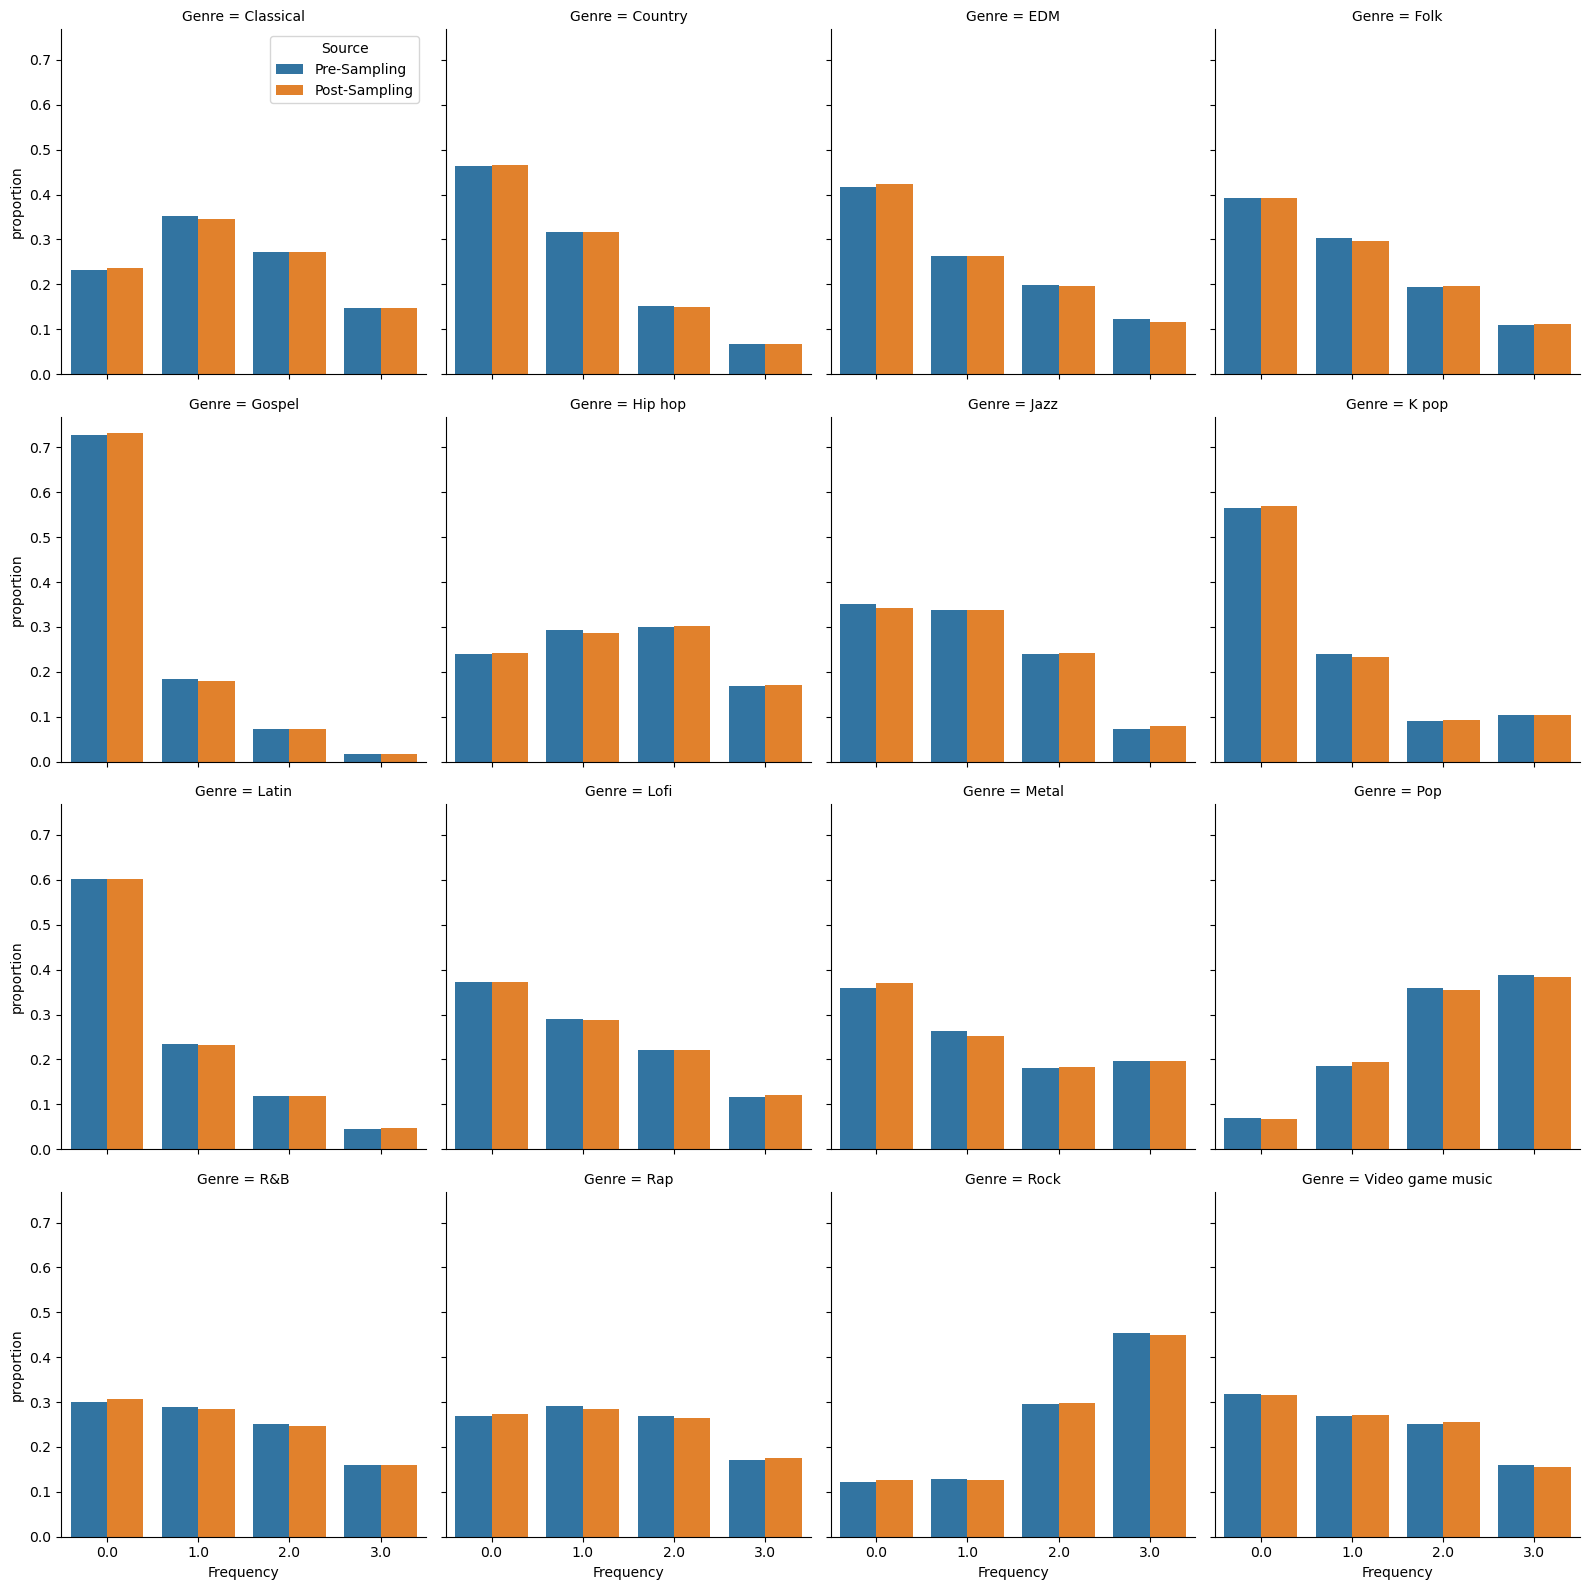

In [151]:
# Plot proportions from both datasets for comparison
grouped_combined = combined_df.groupby(by=['Source', 'Genre']).value_counts(normalize=True).reset_index()

plt.figure(figsize=(12, 6))

sns.catplot(
    data=grouped_combined,
    x='Frequency',
    y='proportion',
    kind='bar',
    col='Genre',
    col_wrap=4,
    hue='Source',
    hue_order=['Pre-Sampling', 'Post-Sampling'],
    height=4,
    dodge=True,
    legend_out=False
)

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'bar_pre_post_tomek.png', dpi=300, bbox_inches='tight')
plt.show()

In [152]:
# Prepare data for plotting in long form

melted_df = df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_resampled_df = resampled_df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_df['Source'] = 'Pre-Undersampling'
melted_resampled_df['Source'] = 'Post-Undersampling'

# Combine into one dataframe
combined_df = pd.concat([melted_df, melted_resampled_df])

# Convert rank to string since ordinal not continuous
combined_df['Rank'] = combined_df['Rank'].astype(int).astype(str)

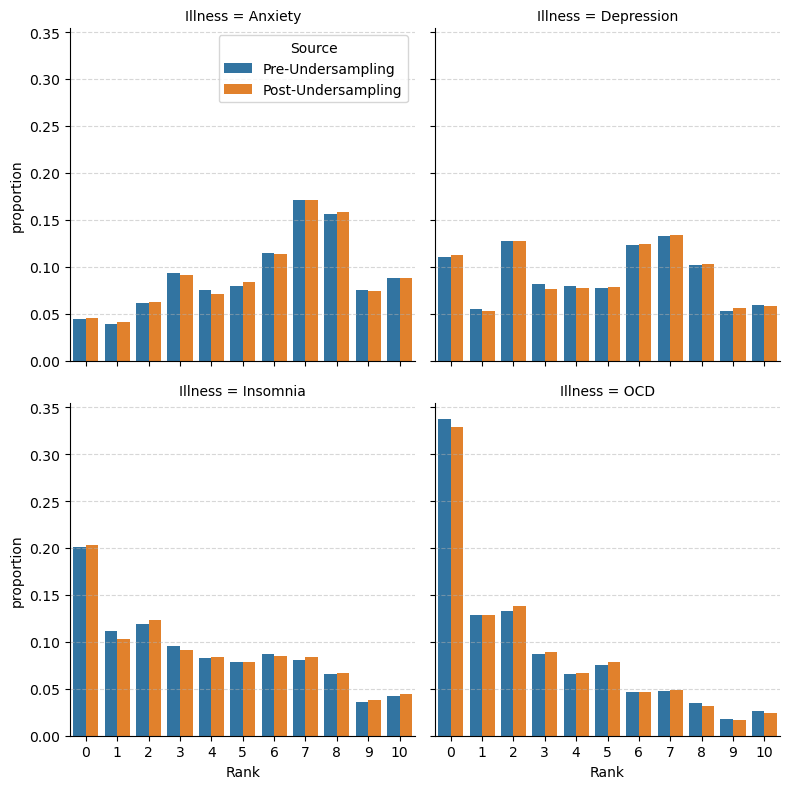

In [153]:
# Plot illness data pre and post undersampling for comparison
grouped_combined = combined_df.groupby(by=['Illness', 'Source']).value_counts(normalize=True).reset_index()

plot = sns.catplot(
    data=grouped_combined,
    x='Rank',
    y='proportion',
    col='Illness',
    col_wrap=2,
    kind='bar',
    hue='Source',
    hue_order=['Pre-Undersampling', 'Post-Undersampling'],
    order=list(range(11)),
    height=4,
    legend_out=False,
)

for ax in plot.axes:
    ax.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'illness_pre_post_tomek.png', dpi=300, bbox_inches='tight')
plt.show()

#### Summary
- Undersampling using **Tomek Links** reduced the dominant class by **~2%**
- Distributions of features **did not significantly change**.

### Undersampling + Oversampling

Applying **SMOTE-NC** following undersampling by **Tomek Links**.

In [154]:
# Split data into features and target

X = df.drop(labels=['improved'], axis=1)
y = df['improved']

In [155]:
# Initialize SMOTE-NC
smote_nc = SMOTENC(categorical_features=cat_cols_indeces)

# Apply to oversample
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Combine resampled data into dataframe
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df = pd.concat([resampled_df, pd.DataFrame(y_resampled, columns=['improved'])], axis=1)

In [156]:
resampled_df.head()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Classical,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music,improved
0,18.0,3.0,156.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0,3,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,63.0,1.5,119.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,7,2,2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,18.0,4.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0,7,7,10,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,61.0,2.5,84.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,9,7,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,18.0,4.0,107.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0,7,2,5,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [158]:
resampled_df.to_csv(INTERIM_DATA_DIR / 'balanced.csv', index=False)

#### Evaluate Continuous

In [159]:
resampled_df['improved']

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
1073    0.0
1074    0.0
1075    0.0
1076    0.0
1077    0.0
Name: improved, Length: 1078, dtype: float64

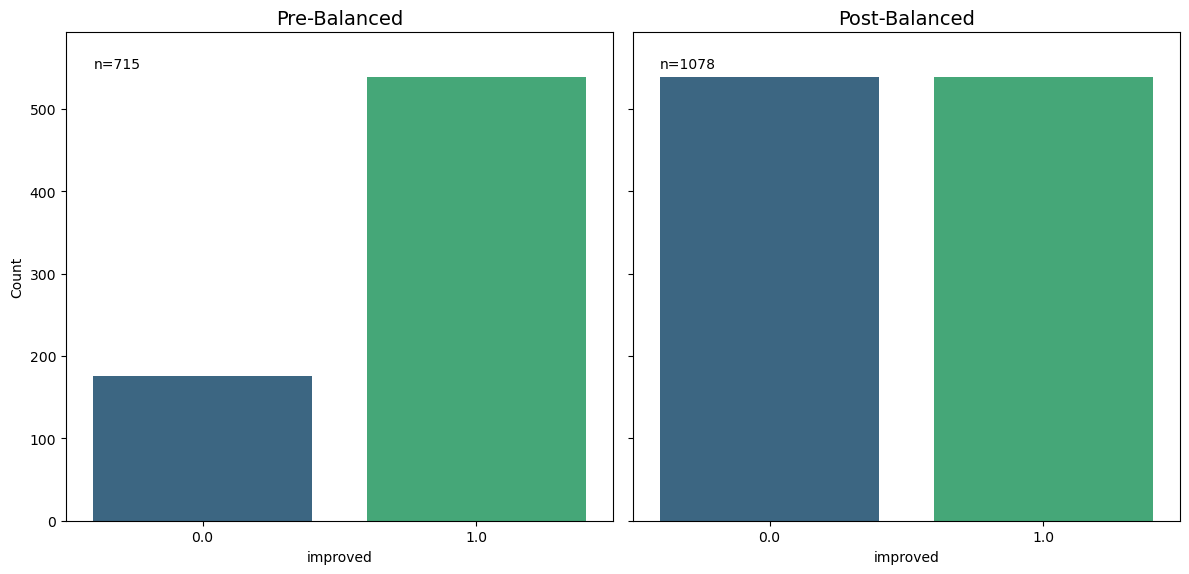

In [160]:
# Plot Improved to see balancing distribution

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharey=True)

fig.suptitle('')

sns.countplot(
    data=df,
    x='improved',
    ax=ax[0],
    palette='viridis',
    hue='improved',
    legend=False
)
ax[0].set_title('Pre-Balanced', fontsize=14)
ax[0].text(0.05, 0.95, transform=ax[0].transAxes, s=f"n={len(df)}", va='top', ha='left')
ax[0].set_ylabel('Count')

sns.countplot(
    data=resampled_df,
    x='improved',
    ax=ax[1],
    hue='improved',
    legend=False,
    palette='viridis'
)
ax[1].set_title('Post-Balanced', fontsize=14)
ax[1].text(0.05, 0.95, transform=ax[1].transAxes, s=f"n={len(resampled_df)}", va='top', ha='left')
ax[1].set_ylim(0, len(resampled_df) / 2 * 1.10)

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'bar_pre_post_balance.png', dpi=300, bbox_inches='tight')
plt.show()

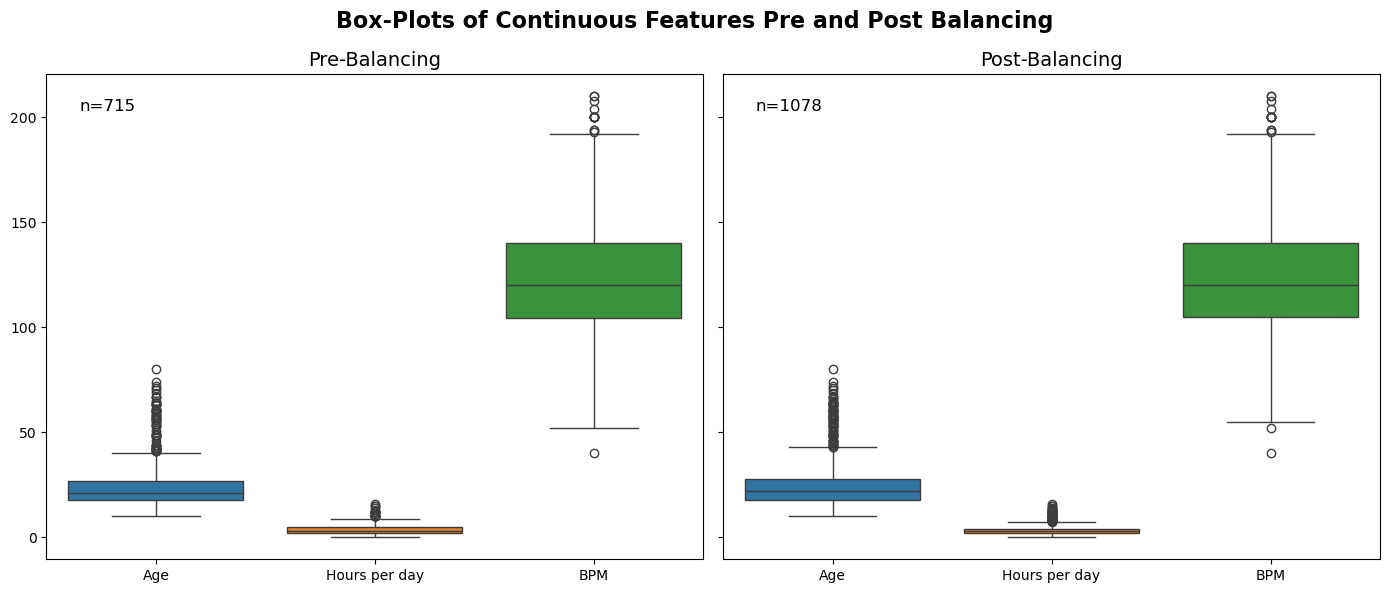

In [161]:
# Plot continuous feature boxplots pre and post imputation

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 6))

fig.suptitle('Box-Plots of Continuous Features Pre and Post Balancing', fontsize=16, fontweight='bold')

sns.boxplot(df[continuous_features], ax=ax[0])
ax[0].set_title('Pre-Balancing', fontsize=14)
ax[0].text(0.05, 0.95, f"n={len(df)}", transform=ax[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

sns.boxplot(resampled_df[continuous_features], ax=ax[1])
ax[1].set_title('Post-Balancing', fontsize=14)
ax[1].text(0.05, 0.95, f"n={len(resampled_df)}", transform=ax[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_balance_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

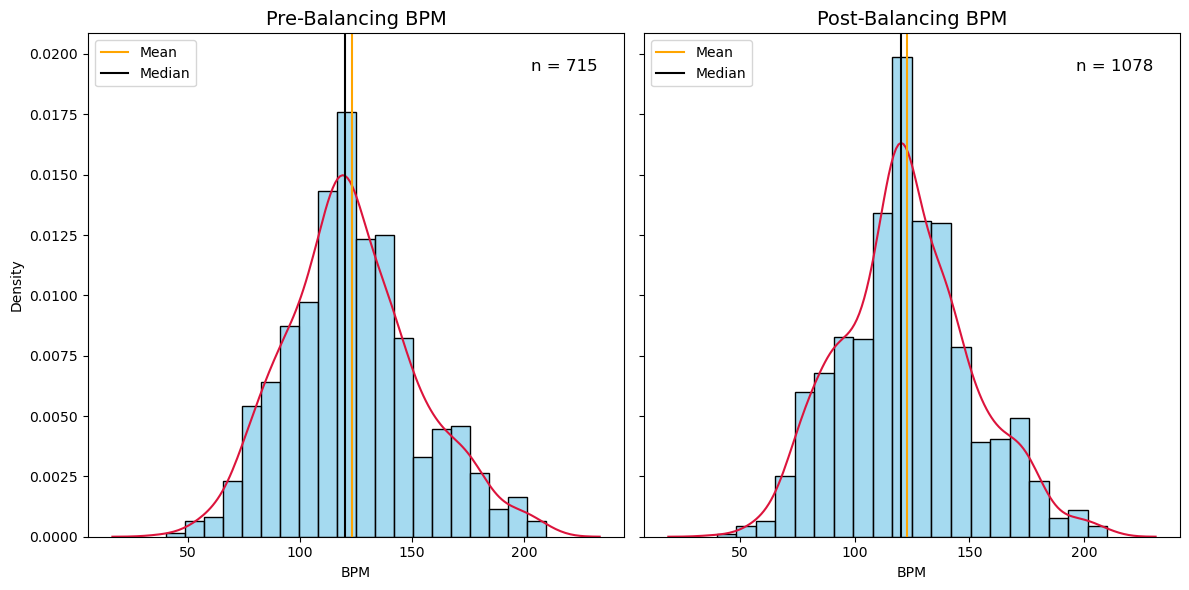

In [162]:
# Plot distributions of BPM pre and post imputation

pre_sampling_mean = np.mean(df['BPM'])
pre_sampling_median = np.median(df['BPM'])
post_sampling_mean = np.mean(resampled_df['BPM'])
post_sampling_median = np.median(resampled_df['BPM'])

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes = ax.flatten()

axes[0].set_title('Pre-Balancing BPM', fontsize=14)
sns.histplot(df['BPM'], stat='density', ax=axes[0], color='skyblue', bins=20)
sns.kdeplot(df['BPM'], ax=axes[0], color='crimson')
axes[0].axvline(pre_sampling_mean, color='orange', label='Mean')
axes[0].axvline(pre_sampling_median, color='black', label='Median')
axes[0].legend()
axes[0].text(0.95, 0.95, f'n = {len(df)}', transform=axes[0].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

axes[1].set_title('Post-Balancing BPM', fontsize=14)
sns.histplot(resampled_df['BPM'], stat='density', color='skyblue', bins=20, ax=axes[1])
sns.kdeplot(resampled_df['BPM'], color='crimson', ax=axes[1])
axes[1].axvline(post_sampling_mean, color='orange', label='Mean')
axes[1].axvline(post_sampling_median, color='black', label='Median')
axes[1].legend()
axes[1].text(0.95, 0.95, f'n = {len(resampled_df)}', transform=axes[1].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'pre_post_balance_bpm.png', dpi=300, bbox_inches='tight')
plt.show()

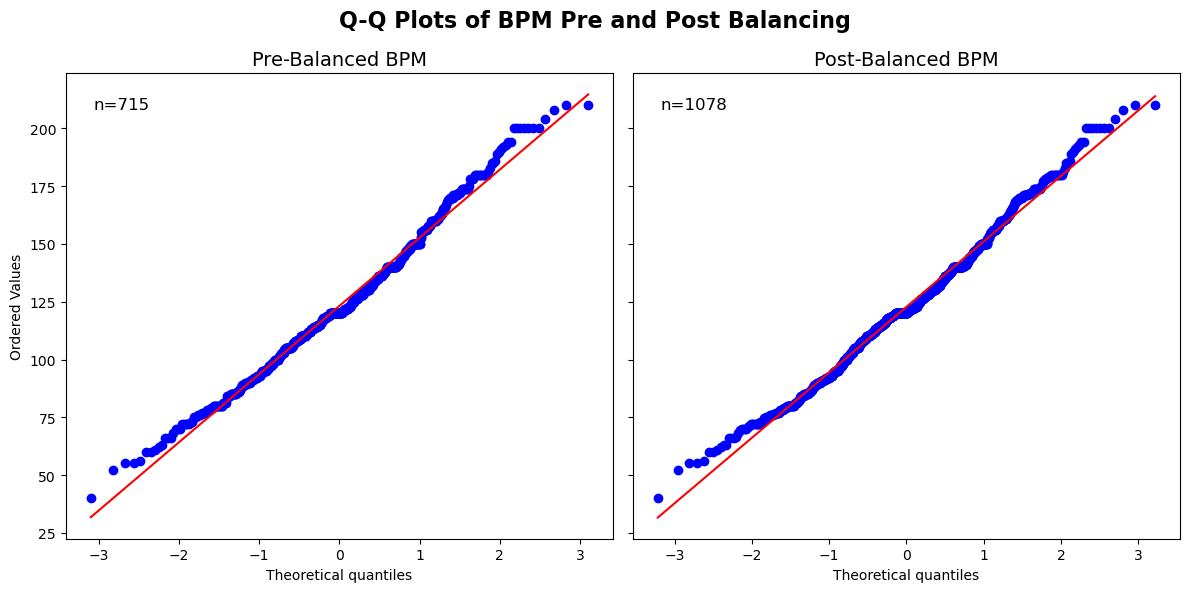

In [163]:
# Plot qq plots to verify normality

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

axes = ax.flatten()

fig.suptitle('Q-Q Plots of BPM Pre and Post Balancing', fontsize=16, fontweight='bold')

plt.sca(axes[0])
stats.probplot(df['BPM'], dist='norm', plot=plt)
axes[0].set_title('Pre-Balanced BPM', fontsize=14)
axes[0].text(0.05, 0.95, s=f"n={len(df)}", transform=axes[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.sca(axes[1])
stats.probplot(resampled_df['BPM'], dist='norm', plot=plt)
axes[1].set_title('Post-Balanced BPM', fontsize=14)
axes[1].set_ylabel('')
axes[1].text(0.05, 0.95, s=f"n={len(resampled_df)}", transform=axes[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'qq_pre_post_balance_bpm.png', dpi=300, bbox_inches='tight')
plt.show()

#### Evaluate Categorical

In [164]:
# Unpivot data for plotting

melted_df = df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_resampled_df = resampled_df[freq_cols].melt(var_name='Genre', value_name='Frequency')
melted_df['Genre'] = melted_df['Genre'].str.strip('Frequency ').str.slice(1, -1)
melted_resampled_df['Genre'] = melted_resampled_df['Genre'].str.strip('Frequency ').str.slice(1, -1)

# Combine into one df

melted_df['Source'] = 'Pre-Balancing'
melted_resampled_df['Source'] = 'Post-Balancing'

combined_df = pd.concat([melted_df, melted_resampled_df])

<Figure size 1200x600 with 0 Axes>

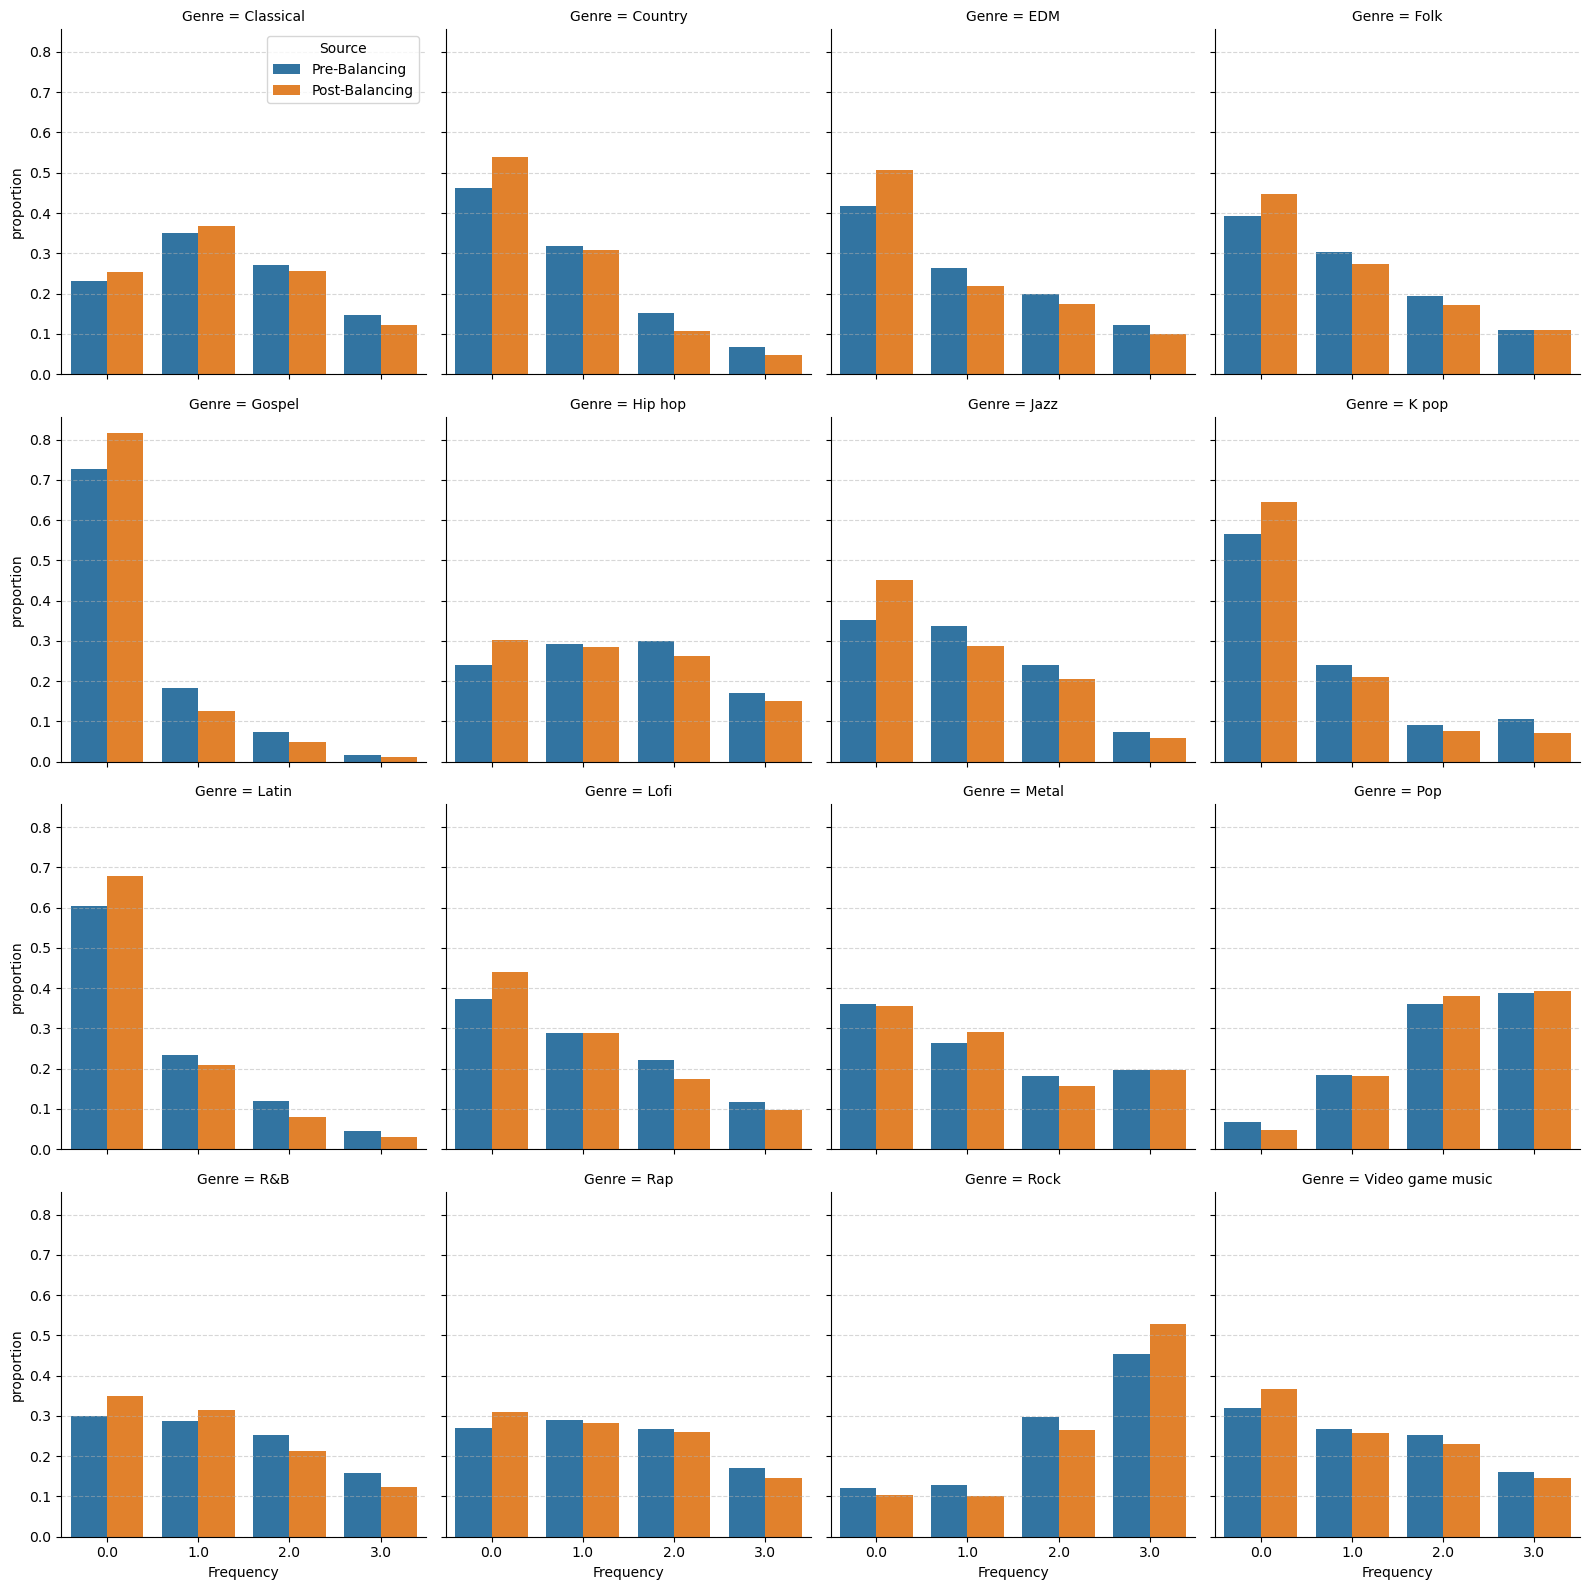

In [165]:
# Plot proportions from both datasets for comparison
grouped_combined = combined_df.groupby(by=['Source', 'Genre']).value_counts(normalize=True).reset_index()

plt.figure(figsize=(12, 6))

plot = sns.catplot(
    data=grouped_combined,
    x='Frequency',
    y='proportion',
    kind='bar',
    col='Genre',
    col_wrap=4,
    hue='Source',
    hue_order=['Pre-Balancing', 'Post-Balancing'],
    height=4,
    dodge=True,
    legend_out=False
)

for ax in plot.axes:
    ax.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'bar_pre_post_balance.png', dpi=300, bbox_inches='tight')
plt.show()

In [166]:
# Prepare data for plotting in long form

melted_df = df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_resampled_df = resampled_df[illness_cols].melt(var_name='Illness', value_name='Rank')
melted_df['Source'] = 'Pre-Balancing'
melted_resampled_df['Source'] = 'Post-Balancing'

# Combine into one dataframe
combined_df = pd.concat([melted_df, melted_resampled_df])

# Convert rank to string since ordinal not continuous
combined_df['Rank'] = combined_df['Rank'].astype(int).astype(str)

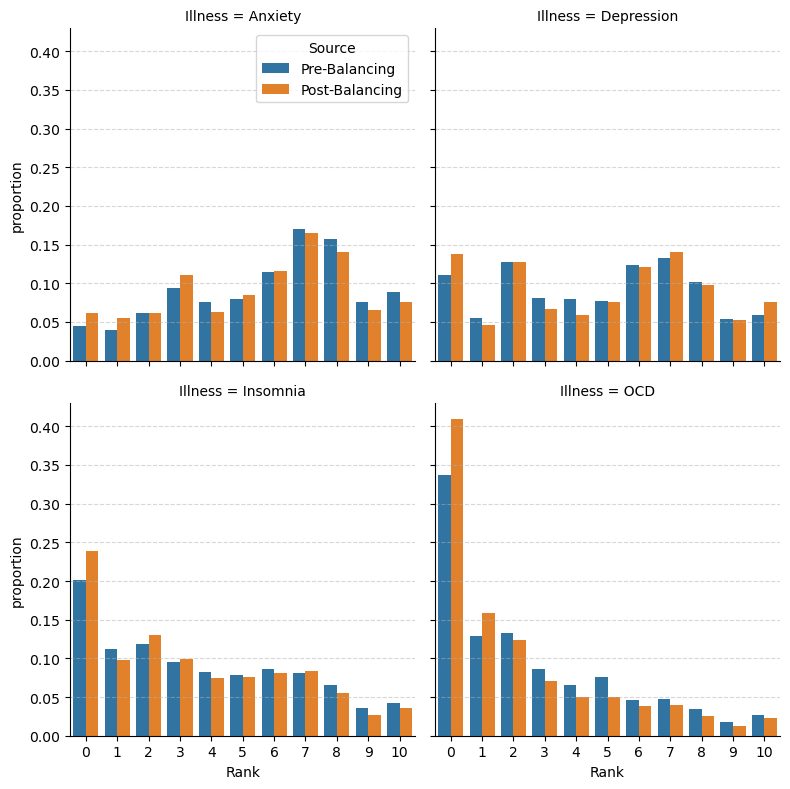

In [167]:
# Plot illness data pre and post balancing for comparison
grouped_combined = combined_df.groupby(by=['Illness', 'Source']).value_counts(normalize=True).reset_index()

plot = sns.catplot(
    data=grouped_combined,
    x='Rank',
    y='proportion',
    col='Illness',
    col_wrap=2,
    kind='bar',
    hue='Source',
    hue_order=['Pre-Balancing', 'Post-Balancing'],
    order=list(range(11)),
    height=4,
    legend_out=False,
)

for ax in plot.axes:
    ax.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(SAMPLING_EVALUATIONS_DIR / 'illness_pre_post_balance.png', dpi=300, bbox_inches='tight')
plt.show()